In [23]:
from __future__ import annotations
import IPython
import tvm
import numpy as np
from tvm import relax
from tvm.script import relax as R
from tvm.script import tir as T
from tvm import IRModule
from tvm import meta_schedule as ms
from tvm.meta_schedule.tir_integration import compile_tir

In [3]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

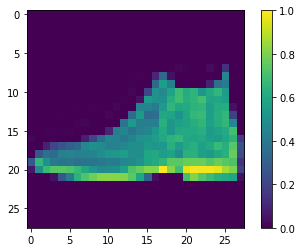

Class: Ankle boot


In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [5]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [6]:
# TensorIR version
@tvm.script.ir_module
class MyModule():
    @T.prim_func
    def linear0(x: T.Buffer[(1, 784), 'float32'],
                w0: T.Buffer[(128, 784), 'float32'],
                b0: T.Buffer[(128,), 'float32'],
                out: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": "linear0", 'tie.noalias': True})
        lv0 = T.alloc_buffer((1, 128), 'float32')
        for i, j, k in T.grid(1, 128, 784):
            with T.block('lv0'):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w0[vj, vk]
        
        for i, j in T.grid(1, 128):
            with T.block('out'):
                vi, vj = T.axis.remap("SS", [i, j])
                out[vi, vj] = lv0[vi, vj] + b0[vj]

    @T.prim_func
    def linear1(x: T.Buffer[(1, 128), 'float32'],
                w1: T.Buffer[(10, 128), 'float32'],
                b1: T.Buffer[(10,), 'float32'],
                out: T.Buffer[(1, 10), 'float32']):
        T.func_attr({"global_symbol": 'linear1', "tir.noalias": True})
        lv0 = T.alloc_buffer((1, 10), 'float32')
        for i, j, k in T.grid(1, 10, 128):
            with T.block('lv0'):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w1[vj, vk]
        
        for i, j in T.grid(1, 10):
            with T.block('out'):
                vi, vj = T.axis.remap("SS", [i, j])
                out[vi, vj] = lv0[vi, vj] + b1[vj]

    @T.prim_func
    def relu(x: T.Buffer[(1, 128), 'float32'],
             out: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": 'relu', 'tir.noalias': True})
        for i, j in T.grid(1, 128):
            with T.block('out'):
                vi, vj = T.axis.remap("SS", [i, j])
                out[vi, vj] = T.max(x[vi, vj], T.float32(0))
    
    @R.function
    def main(x: R.Tensor((1, 784), 'float32'),
             w0: R.Tensor((128, 784), 'float32'),
             b0: R.Tensor((128,), 'float32'),
             w1: R.Tensor((10, 128), 'float32'),
             b1: R.Tensor((10,), 'float32')):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), 'float32'))
            lv1 = R.call_tir(relu, (lv0, ), relax.TensorStructInfo((1, 128), 'float32'))
            out = R.call_tir(linear1, (lv1, w1, b1), relax.TensorStructInfo((1, 10), 'float32'))
            R.output(out)
        
        return out

In [8]:
IPython.display.Code(MyModule.script(), language='python')

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear1(x: T.Buffer[(1, 128), "float32"], w1: T.Buffer[(10, 128), "float32"], b1: T.Buffer[10, "float32"], out: T.Buffer[(1, 10), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear1"})
        # body
        # with T.block("root")
        lv0 = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(x[vi, vk], w1[vj, vk])
                T.writes(lv0[vi, vj])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w1[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(lv0[vi, vj], b1[vj])
                T.writes(out[vi, vj])
                out[vi, vj] = lv0[vi, vj] + b1[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(relu, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out
        
    @T.prim_func
    def relu(x: T.Buffer[(1, 128), "float32"], out: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "relu"})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(x[vi, vj])
                T.writes(out[vi, vj])
                out[vi, vj] = T.max(x[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear0(x: T.Buffer[(1, 784), "float32"], w0: T.Buffer[(128, 784), "float32"], b0: T.Buffer[128, "float32"], out: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tie.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        lv0 = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(x[vi, vk], w0[vj, vk])
                T.writes(lv0[vi, vj])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w0[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(lv0[vi, vj], b0[vj])
                T.writes(out[vi, vj])
                out[vi, vj] = lv0[vi, vj] + b0[vj]

In [9]:
# bindparams
MyModuleWithParams = relax.transform.BindParams('main', nd_params)(MyModule)
IPython.display.Code(MyModuleWithParams.script(), language='python')

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear1(x: T.Buffer[(1, 128), "float32"], w1: T.Buffer[(10, 128), "float32"], b1: T.Buffer[10, "float32"], out: T.Buffer[(1, 10), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear1"})
        # body
        # with T.block("root")
        lv0 = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(x[vi, vk], w1[vj, vk])
                T.writes(lv0[vi, vj])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w1[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(lv0[vi, vj], b1[vj])
                T.writes(out[vi, vj])
                out[vi, vj] = lv0[vi, vj] + b1[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(relu, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(linear1, (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out
        
    @T.prim_func
    def relu(x: T.Buffer[(1, 128), "float32"], out: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "relu"})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(x[vi, vj])
                T.writes(out[vi, vj])
                out[vi, vj] = T.max(x[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear0(x: T.Buffer[(1, 784), "float32"], w0: T.Buffer[(128, 784), "float32"], b0: T.Buffer[128, "float32"], out: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tie.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        lv0 = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(x[vi, vk], w0[vj, vk])
                T.writes(lv0[vi, vj])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w0[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("out"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(lv0[vi, vj], b0[vj])
                T.writes(out[vi, vj])
                out[vi, vj] = lv0[vi, vj] + b0[vj]

In [14]:
# timer1
ex = relax.vm.build(MyModuleWithParams, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())
f_timer_before = vm.time_evaluator('main', tvm.cpu(), number=1000)
print('time_before is %.6s ms:' %(f_timer_before(data_nd).mean * 1e3))
nd_res = vm['main'](data_nd)
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])


time_before is 0.1033 ms:
MyModuleWithParams Prediction: Ankle boot


In [22]:
# tune version
# linear0
mod_linear = IRModule.from_expr(MyModuleWithParams['linear0'].with_attr("global_symbol", "main"))

In [24]:
linear_record = ms.tune_tir(mod_linear, target='llvm --num-cores=1',
                            work_dir='./tune_tmp/',
                            task_name='main',
                            max_trials_global=64,
                            num_trials_per_iter=64)

2023-02-09 13:47:32 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,41.5701,4.8312,4.8312,64,Y


2023-02-09 13:47:32 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        41.5701 |       4.8312 |                4.8312 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 4.83117



In [26]:
sch_tuned_linear = compile_tir(linear_record, mod_linear, target='llvm')
new_func = sch_tuned_linear.mod['main'].with_attr("global_symbol", 'linear')
gv = MyModuleWithParams.get_global_var('linear0')
MyModuleWithParams.update_func(gv, new_func)
# IPython.display.Code(MyModuleWithParams.script(), language='python')